In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import Dataset

In [78]:
class time_series_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
        
        self.masks = self._generate_square_subsequent_mask(24)
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {"x":self.x[idx,0:t0],
                  "x_next":self.x[idx,:t0:t0+24],
                  "fx": self.fx[idx,0:t0],
                  "fx_next":self.fx[idx,t0:t0+24],
                  "attention_masks":self.masks}
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.tril(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float(0.0)).masked_fill(mask == 1, float('-inf'))
        return mask

In [79]:
t0 = 96
N = 100

In [80]:
dataset = time_series_paper(t0,N)

x: 100*120 fx: 100*120


In [87]:
dataset.masks

tensor([[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -

In [82]:
dataset.fx

tensor([[ 72.0000,  82.9414,  90.9510,  ...,  56.5266,  61.0586,  66.3364],
        [ 72.0000,  98.0525, 117.1242,  ...,  35.1563,  45.9475,  58.5143],
        [ 72.0000,  94.5711, 111.0942,  ...,  40.0797,  49.4289,  60.3164],
        ...,
        [ 72.0000,  99.9820, 120.4663,  ...,  32.4274,  44.0180,  57.5155],
        [ 72.0000,  89.4505, 102.2251,  ...,  45.9469,  53.5777,  62.4640],
        [ 72.0000,  72.9932,  73.7202,  ...,  57.4860,  61.7371,  66.6875]])

In [83]:
dataset.x

tensor([[  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        ...,
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.]])

In [84]:
dataset[0]

{'x': tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
         56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
         70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
         84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.]),
 'x_next': tensor([0.]),
 'fx': tensor([ 72.0000,  82.9414,  90.9510,  93.8828,  90.9510,  82.9414,  72.0000,
          61.0586,  53.0490,  50.1173,  53.0490,  61.0586,  72.0000,  75.2307,
          77.5957,  78.4614,  77.5957,  75.2307,  72.0000,  68.7693,  66.4043,
          65.5386,  66.4043,  68.7693,  72.0000,  88.9911, 101.4294, 105.9821,
         101.4294,  88.9911,  72.0000,  55.0089,  42.5706,  38.0179,  42.5706,
          55.0090,  72.0

In [85]:
encoded_dict =  dataset[0]

In [86]:
for key,value in encoded_dict.items():
    print("{}: ".format(key),value.shape)

x:  torch.Size([96])
x_next:  torch.Size([1])
fx:  torch.Size([96])
fx_next:  torch.Size([24])
attention_masks:  torch.Size([24, 24])


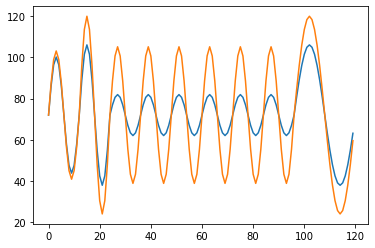

In [61]:
plt.plot(dataset.x[1].numpy(),dataset.fx[1].numpy())
plt.plot(dataset.x[2].numpy(),dataset.fx[2].numpy())
plt.show()